# REINFORCE-Pong using PyTorch

This Notebook reimplements a REINFORCE agent in Pytorch with GPU acceleration and trains it to play Pong.

We basically takes PyTorch's REINFORCE implementation for Cartpole as the starter code, and adapt it to play Pong. It results in a 2-week coding marathon as we step through 6 iterations of this REINFORCE code.

The end result is a REINFORCE agent built on PyTorch which can only achieve parity with the game AI (running reward of -1.0), significantly underperforming Karpathy's implementation.

We discover that in policy-based RL, there are many local optima in the policy landscape. The agent can easily get trapped in these local optima and get content being "King of the Small Hill", even though there is the Himalayas out there.

The basic explore-exploit problem can be solved using temperature in the softmax classifier, and this is the basis of our single agent Actor-Critic implementation, which exceeds Karpathy's REINFORCE performance in fewer number of training episodes:

https://github.com/LUKELIEM/actor-critic


In [5]:
# As usual, a bit of setup
from __future__ import print_function
import time
import numpy as np
import matplotlib.pyplot as plt
import platform
import gym
import pickle as pickle
import pympler

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.distributions import Categorical
import gc

# For advanced computer vision to play with downsampling techniques
import cv2

# For memory tracking
from pympler import summary
from pympler import muppy

cpu_dtype = torch.FloatTensor
gpu_dtype = torch.cuda.FloatTensor

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

print("Python version: ", platform.python_version())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Python version:  3.6.3


## REINFORCE-Pong V1

In our first attempt, we repeatedly encounter GPU memory errors such as the one shown.

REINFORCE and other policy gradient training workflow is very memory intensive. Instead of performing a forward pass on the data followed by a backward pass as in image classification, policy-based RL involves running the forward pass hundreds to thousands of games steps in an episode (depending on the game), accumulating a stack of rewards and log-probability along the way, then using these accumulated data to perform a single backward pass to update the policy parameters.

Our original 2-layer NN turn out to have 1.3 parameters (6400x200+misc). Multiply this by 1000-10000 game steps and the memory requirement will exceed the 11Gb memory currently on our GPU.

```
Episode 1280	Last Reward: -17.00	Running Reward: -16.27
---------------------------------------------------------------------------
RuntimeError                              Traceback (most recent call last)
<ipython-input-7-846e36881c4d> in <module>()
    191 
    192     # Calculate policy gradient and update Policy
--> 193     finish_episode()
    194 
    195     gc.collect()  # clean up some garbage

<ipython-input-7-846e36881c4d> in finish_episode()
    133     # The TRICK: backward() on policy_loss instead of policy
    134     # Policy's parameters are updated here.
--> 135     policy_loss.backward()
    136     optimizer.step()
    137 

~/miniconda3/lib/python3.6/site-packages/torch/autograd/variable.py in backward(self, gradient, retain_graph, create_graph, retain_variables)
    165                 Variable.
    166         """
--> 167         torch.autograd.backward(self, gradient, retain_graph, create_graph, retain_variables)
    168 
    169     def register_hook(self, hook):

~/miniconda3/lib/python3.6/site-packages/torch/autograd/__init__.py in backward(variables, grad_variables, retain_graph, create_graph, retain_variables)
     97 
     98     Variable._execution_engine.run_backward(
---> 99         variables, grad_variables, retain_graph)
    100 
    101 

RuntimeError: cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1512386481460/work/torch/lib/THC/generic/THCStorage.cu:58
```

In [ ]:
import argparse
import gym
import numpy as np
from itertools import count

# For memory tracking
from pympler import summary
from pympler import muppy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.distributions import Categorical
import gc

gamma=0.99
seed=543
render=False
log_interval=10
verbose=False  # To step through the code and understand what is going on

reinforce=[]

env = gym.make("Pong-v0")
env.seed(seed)
torch.manual_seed(seed)

# The function approximator of the Policy is a 2 layer NN. 
# - The policy takes in the state of Pong, which is a resampled 40x40 image
# - The action is the softmax output (Left or Right)
# - there are 200 hidden units in the NN
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.affine1 = nn.Linear(1600, 200)
        self.affine2 = nn.Linear(200, 2)  
        
        self.saved_log_probs = []
        self.rewards = []

    def forward(self, x):
        x = F.relu(self.affine1(x))
        action_scores = self.affine2(x)
        return F.softmax(action_scores, dim=1)

# Call an instance of the Policy and select ADAM as update rule
policy = Policy().cuda()
optimizer = optim.Adam(policy.parameters(), lr=1e-3)


def prepro(I):
    """ 
    prepro 210x160x3 uint8 frame into 1600 (40x40) 1D float vector 
    """
    I = I[35:195] # crop
    I = I[::4,::4,0] # downsample by factor of 4
    I[I == 144] = 0 # erase background (background type 1)
    I[I == 109] = 0 # erase background (background type 2)
    I[I != 0] = 1 # everything else (paddles, ball) just set to 1
    return I.astype(np.float).ravel()


def select_action(state):
    """ 
    Use Policy to select an action based on state returned by Pong. The output expected by the PONG 
    is:
    ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']
    
    So we need to return 2 (UP/RIGHT) and 3(DOWN/LEFT)
    """
    
    state = torch.from_numpy(state).float().unsqueeze(0)
    if verbose:
        print ("Pong's state output:", state.shape, state)
    
    # Use Policy to generate probability for action
    probs = policy(Variable(state.type(gpu_dtype), requires_grad=False))

    # Sample action stochastically    
    m = Categorical(probs)
    action = m.sample()
    if verbose:
        print ("Pong Action:", action.data[0]+2)
        print ("log_prob(action):", m.log_prob(action))
        
    # Store log_prob (score function) into a list for calculating policy gradient    
    policy.saved_log_probs.append(m.log_prob(action))
    
    del state, probs, m
    
    return action.data[0]+2  # UP=2, DOWN=3


def finish_episode():
    """ 
    Based on REINFORCE, policy gradient is calculated at the end of an episode.
    It is then used to update the Policy's weights
    """

    R = 0
    policy_loss = []
    rewards = []   # This is v_t
    
    if verbose:
        print ("Rewards:", policy.rewards)
    
    # In the main loop, reward for each time step is stored in the list policy.rewards[].
    # At the end of the episode, this is used to generate v_t for each time step.
    for r in policy.rewards[::-1]:
        R = r + gamma * R
        rewards.insert(0, R)
    rewards = torch.Tensor(rewards)
    rewards = (rewards - rewards.mean()) / (rewards.std() + np.finfo(np.float32).eps)
    if verbose:
        print ("v_t:", rewards)   

    # Calculate policy gradient ∇_θ log (π_θ ( s_t , a_t ) )v_t
    for log_prob, reward in zip(policy.saved_log_probs, rewards):
        policy_loss.append(-log_prob * reward)   # negative because gradient descent

    if verbose:
        print ("Policy Gradient:", policy_loss)  
        
    optimizer.zero_grad()  # zero the gradients before running the optimizer
    
    # Sum policy gradients for all time steps in the episode
    policy_loss = torch.cat(policy_loss).sum()   
    if verbose:
        print ("Policy loss (after cat and sum):", policy_loss)  
        
    # The TRICK: backward() on policy_loss instead of policy
    # Policy's parameters are updated here.
    policy_loss.backward()  
    optimizer.step()
    
    del rewards, policy_loss  # start deleting stuffs to address memory leak
    del policy.rewards[:]
    del policy.saved_log_probs[:]


# Main loop
prev_x = None
running_reward = -21

start = time.time()
# for i_episode in count(1):  # Infinite loop
for i_episode in range(30000): # just run 30000 episode    
    state = env.reset()
    reward_sum = 0
    
    for t in range(10000):  # Don't infinite loop while learning
        
        # Downsample 210x160x3 frame into 1600 (80x80) 1D float vector
        cur_x = prepro(state)
        state = cur_x - prev_x if prev_x is not None else np.zeros(1600)
        prev_x = cur_x
        
        # Sample an action from Policy based on state provided by env
        action = select_action(state)
        
        #state = torch.from_numpy(state).float().unsqueeze(0)
    
        # Use Policy to generate probability for action
        # probs = policy(Variable(state.type(gpu_dtype), requires_grad=False))

        # Sample action stochastically    
        # m = Categorical(probs)
        # action = m.sample()
        
        # Store log_prob (score function) into a list for calculating policy gradient    
        # policy.saved_log_probs.append(m.log_prob(action))
        
        # step env through the sampled action
        state, reward, done, _ = env.step(action)  # UP=2, DOWN=3
        reward_sum += reward
        
        if render:
            env.render()
            
        # append reward to policy.reward[]
        # this is needed to calculate policy gradient at the end of the episode  
        policy.rewards.append(reward)
        
        # break if episode is done
        if done:
            break
    
    running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
    
    # Calculate policy gradient and update Policy 
    finish_episode()
    
    gc.collect()  # clean up some garbage
    torch.cuda.empty_cache()  # Release GPU memory
   
    reinforce.append([reward_sum, running_reward])
    # print out and show sign of life
    if i_episode % log_interval == 0:
        print('Episode {}\tLast Reward: {:.2f}\tRunning Reward: {:.2f}'.format(
                i_episode, reward_sum, running_reward))
    
    # track memory usage every 100 episodes
    if i_episode % 2000 == 0:
         summary.print_(summary.summarize(muppy.get_objects()))
         file_name = './results/reinforce/pong_'+'ep='+str(i_episode)+'model.pt'
         torch.save(policy.state_dict(), file_name)


end = time.time()
print ("Time taken:", start-end)

## REINFORCE-Pong V2

We address the GPU memory error problem by limiting the number of game steps per episode and by emptying the torch's cuda cache after each backprop.

Our agent no longer run into GPU memory error. After 30000 episodes of training, it can barely keep up with the game AI, losing 1.0 game on average. 

```
Episode 29990	Last Reward: -1.00	Running Reward: -0.56
Time taken: -23134.681317329407
```

We have run into the local optima problem of policy-based RL. We did not know this at first and went through iterations V3-6 to identify this underperformance problem.

In [ ]:
import argparse
import gym
import numpy as np
from itertools import count

# For memory tracking
from pympler import summary
from pympler import muppy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.distributions import Categorical
import gc

gamma=0.99
seed=543
render=False
log_interval=10
batch_size = 800
verbose=False  # To step through the code and understand what is going on

reinforce=[]

env = gym.make("Pong-v0")
env.seed(seed)
torch.manual_seed(seed)

# The function approximator of the Policy is a 2 layer NN. 
# - The policy takes in the state of Pong, which is a resampled 40x40 image
# - The action is the softmax output (Left or Right)
# - there are 200 hidden units in the NN
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.affine1 = nn.Linear(1600, 200)
        self.affine2 = nn.Linear(200, 2)  
        
        self.saved_log_probs = []
        self.rewards = []

    def forward(self, x):
        x = F.relu(self.affine1(x))
        action_scores = self.affine2(x)
        return F.softmax(action_scores, dim=1)

# Call an instance of the Policy and select ADAM as update rule
policy = Policy().cuda()
optimizer = optim.Adam(policy.parameters(), lr=1e-3)


def prepro(I):
    """ 
    prepro 210x160x3 uint8 frame into 1600 (40x40) 1D float vector 
    """
    I = I[35:195] # crop
    I = I[::4,::4,0] # downsample by factor of 4
    I[I == 144] = 0 # erase background (background type 1)
    I[I == 109] = 0 # erase background (background type 2)
    I[I != 0] = 1 # everything else (paddles, ball) just set to 1
    return I.astype(np.float).ravel()


def select_action(state):
    """ 
    Use Policy to select an action based on state returned by Pong. The output expected by the PONG 
    is:
    ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']
    
    So we need to return 2 (UP/RIGHT) and 3(DOWN/LEFT)
    """
    
    state = torch.from_numpy(state).float().unsqueeze(0)
    if verbose:
        print ("Pong's state output:", state.shape, state)
    
    # Use Policy to generate probability for action
    probs = policy(Variable(state.type(gpu_dtype), requires_grad=False))

    # Sample action stochastically    
    m = Categorical(probs)
    action = m.sample()
    if verbose:
        print ("Pong Action:", action.data[0]+2)
        print ("log_prob(action):", m.log_prob(action))
        
    # Store log_prob (score function) into a list for calculating policy gradient    
    policy.saved_log_probs.append(m.log_prob(action))
    
    del state, probs, m
    
    return action.data[0]+2  # UP=2, DOWN=3


def finish_batch():
    """ 
    Based on REINFORCE, policy gradient is computed at the end of a batch (instead of an
    episode). It is then used to update the Policy's weights
    """

    R = 0
    policy_loss = []
    rewards = []   # This is v_t
    
    if verbose:
        print ("Rewards:", policy.rewards)
    
    # In the main loop, reward for each time step is stored in the list policy.rewards[].
    # At the end of the episode, this is used to generate v_t for each time step.
    for r in policy.rewards[::-1]:
        R = r + gamma * R
        rewards.insert(0, R)
    rewards = torch.Tensor(rewards)
    rewards = (rewards - rewards.mean()) / (rewards.std() + np.finfo(np.float32).eps)
    if verbose:
        print ("v_t:", rewards)   

    # Calculate policy gradient ∇_θ log (π_θ ( s_t , a_t ) )v_t
    for log_prob, reward in zip(policy.saved_log_probs, rewards):
        policy_loss.append(-log_prob * reward)   # negative because gradient descent

    if verbose:
        print ("Policy Gradient:", policy_loss)  
        
    optimizer.zero_grad()  # zero the gradients before running the optimizer
    
    # Sum policy gradients for all time steps in the episode
    policy_loss = torch.cat(policy_loss).sum()   
    if verbose:
        print ("Policy loss (after cat and sum):", policy_loss)  
        
    # The TRICK: backward() on policy_loss instead of policy
    # Policy's parameters are updated here.
    policy_loss.backward()  
    optimizer.step()
    
    del rewards, policy_loss  # start deleting stuffs to address memory leak
    del policy.rewards[:]
    del policy.saved_log_probs[:]


# Main loop
prev_x = None
running_reward = -15

start = time.time()
# for i_episode in count(1):  # Infinite loop
for i_episode in range(30000): # just run 30000 episode    
    state = env.reset()
    reward_sum = 0
    
    for t in range(10000):  # Don't infinite loop while learning
        
        # Downsample 210x160x3 frame into 1600 (80x80) 1D float vector
        cur_x = prepro(state)
        state = cur_x - prev_x if prev_x is not None else np.zeros(1600)
        prev_x = cur_x
        
        # Sample an action from Policy based on state provided by env
        action = select_action(state)
        
        # step env through the sampled action
        state, reward, done, _ = env.step(action)  # UP=2, DOWN=3
        reward_sum += reward
        
        if render:
            env.render()
            
        # append reward to policy.reward[]
        # this is needed to calculate policy gradient at the end of the episode  
        policy.rewards.append(reward)
        
        if done or t > batch_size:
            break
        

    # Calculate policy gradient and update Policy 
    finish_batch()
    gc.collect()  # clean up some garbage
    torch.cuda.empty_cache()  # Release GPU memory
    
    running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
   
    reinforce.append([reward_sum, running_reward])
    # print out and show sign of life
    if i_episode % log_interval == 0:
        print('Episode {}\tLast Reward: {:.2f}\tRunning Reward: {:.2f}'.format(
                i_episode, reward_sum, running_reward))
    
    # track memory usage every 100 episodes
    if i_episode % 2000 == 0:
         summary.print_(summary.summarize(muppy.get_objects()))
         file_name = './results/reinforce/pong_'+'ep='+str(i_episode)+'model.pt'
         torch.save(policy.state_dict(), file_name)


end = time.time()
print ("Time taken:", start-end)

## Save Result

We save the results in ./gym/results/reinforce/pong_ep=30000history.p

In [19]:
file_name = './results/reinforce/pong_'+'ep='+str(i_episode+1)+'history.p'
pickle.dump(reinforce, open(file_name, 'wb'))

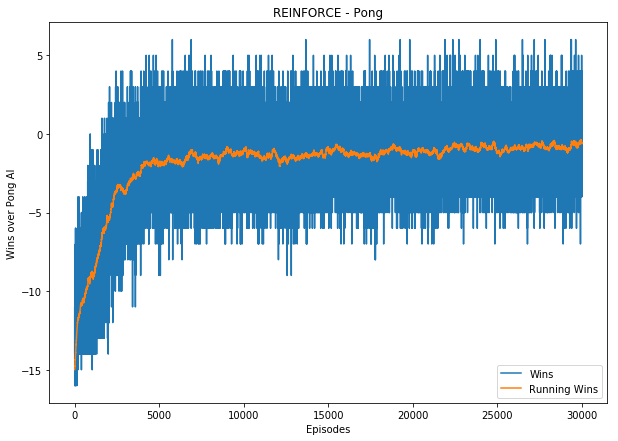

In [7]:
data = pickle.load(open('./results/reinforce/reinforce-v2/pong_ep=30000history.p', 'rb'))

# Plot out reward and running reward over training episodes
plt.figure(figsize=(10, 7))

plt.plot(list(range(1,len(np.array(data)[:,0])+1)), np.array(data)[:,0], label='Wins')
plt.plot(list(range(1,len(np.array(data)[:,1])+1)), np.array(data)[:,1], label='Running Wins')
plt.title('REINFORCE - Pong')
plt.xlabel('Episodes')
plt.ylabel('Wins over Pong AI')
plt.legend()
plt.show()

## Does worse than REINFORCE-Karpathy


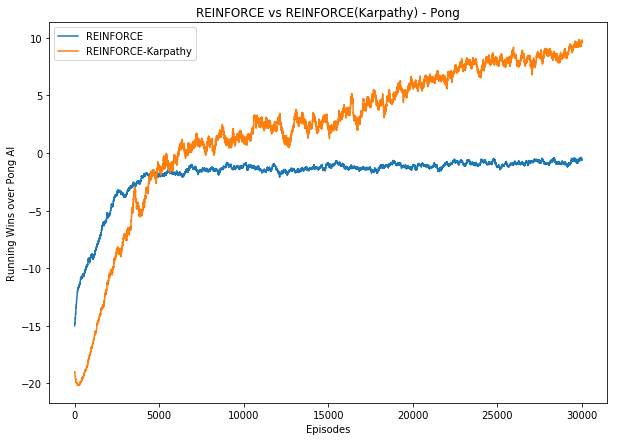

In [8]:
data1 = pickle.load(open('./results/reinforce/reinforce-v2/pong_ep=30000history.p', 'rb'))
data2 = pickle.load(open('./results/pg-numpy/reward_history-pg-numpy-30000ep-lr-1e-3.p', 'rb'))

# Plot out reward and running reward over training episodes
plt.figure(figsize=(10, 7))


plt.plot(list(range(1,len(data1)+1)), np.array(data1)[:,1], label='REINFORCE')
plt.plot(list(range(1,len(data2)+1)), np.array(data2)[:,1], label='REINFORCE-Karpathy')
plt.title('REINFORCE vs REINFORCE(Karpathy) - Pong')
plt.xlabel('Episodes')
plt.ylabel('Running Wins over Pong AI')
plt.legend()
plt.show()


## REINFORCE-Pong V3-4

We tried a series of things to identify the performance discrepancies between Pytorch's implementation and REINFORCE-Karpathy:

(1) Downsampling - Not the problem  
(2) Batchsize - Not the problem  
(3) Update Rule - Not the problem


In [ ]:
import argparse
import gym
import numpy as np
from itertools import count

# For memory tracking
from pympler import summary
from pympler import muppy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.distributions import Categorical
import gc

gamma=0.99
seed=543
render=False
log_interval=100
batch_size = 1000  # Debug Underperformance - (2) change batch_size
verbose=False  # To step through the code and understand what is going on

reinforce=[]

env = gym.make("Pong-v0")
env.seed(seed)
torch.manual_seed(seed)

# The function approximator of the Policy is a 2 layer NN. 
# - The policy takes in the state of Pong, which is a resampled 40x40 image
# - The action is the softmax output (Left or Right)
# - there are 200 hidden units in the NN
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.affine1 = nn.Linear(6400, 200)
        self.affine2 = nn.Linear(200, 2)  
        
        self.saved_log_probs = []
        self.rewards = []

    def forward(self, x):
        x = F.relu(self.affine1(x))
        action_scores = self.affine2(x)
        return F.softmax(action_scores, dim=1)


# Debug Underperformance - (1) Change downsampling
def prepro80(I):
    """ 
    prepro 210x160x3 uint8 frame into 6400 (80x80) 1D float vector 
    """
    I = I[35:195] # crop
    I = I[::2,::2,0] # downsample by factor of 2
    I[I == 144] = 0 # erase background (background type 1)
    I[I == 109] = 0 # erase background (background type 2)
    I[I != 0] = 1 # everything else (paddles, ball) just set to 1
    return I.astype(np.float).ravel()


def select_action(state):
    """ 
    Use Policy to select an action based on state returned by Pong. The output expected by the PONG 
    is:
    ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']
    
    So we need to return 2 (UP/RIGHT) and 3(DOWN/LEFT)
    """
    
    state = torch.from_numpy(state).float().unsqueeze(0)
    if verbose:
        print ("Pong's state output:", state.shape, state)
    
    # Use Policy to generate probability for action
    probs = policy(Variable(state.type(gpu_dtype), requires_grad=False))

    # Sample action stochastically    
    m = Categorical(probs)
    action = m.sample()
    if verbose:
        print ("Pong Action:", action.data[0]+2)
        print ("log_prob(action):", m.log_prob(action))
        
    # Store log_prob (score function) into a list for calculating policy gradient    
    policy.saved_log_probs.append(m.log_prob(action))
    
    del state, probs, m
    
    return action.data[0]+2  # UP=2, DOWN=3


def finish_batch(optimizer):
    """ 
    Based on REINFORCE, policy gradient is computed at the end of a batch (instead of an
    episode). It is then used to update the Policy's weights
    """

    R = 0
    policy_loss = []
    rewards = []   # This is v_t
    
    if verbose:
        print ("Rewards:", policy.rewards)
    
    # In the main loop, reward for each time step is stored in the list policy.rewards[].
    # At the end of the episode, this is used to generate v_t for each time step.
    for r in policy.rewards[::-1]:
        R = r + gamma * R
        rewards.insert(0, R)
    rewards = torch.Tensor(rewards)
    rewards = (rewards - rewards.mean()) / (rewards.std() + np.finfo(np.float32).eps)
    if verbose:
        print ("v_t:", rewards)   

    # Calculate policy gradient ∇_θ log (π_θ ( s_t , a_t ) )v_t
    for log_prob, reward in zip(policy.saved_log_probs, rewards):
        policy_loss.append(-log_prob * reward)   # negative because gradient descent

    if verbose:
        print ("Policy Gradient:", policy_loss)  
        
    optimizer.zero_grad()  # zero the gradients before running the optimizer
    
    # Sum policy gradients for all time steps in the episode
    policy_loss = torch.cat(policy_loss).sum()   
    if verbose:
        print ("Policy loss (after cat and sum):", policy_loss)  
        
    # The TRICK: backward() on policy_loss instead of policy
    # Policy's parameters are updated here.
    policy_loss.backward()  
    optimizer.step()
    
    del rewards, policy_loss  # start deleting stuffs to address memory leak
    del policy.rewards[:]
    del policy.saved_log_probs[:]

# Main loop
# Try out different optimizers
names =['RmsProp-lr=1e-3', 'SGD-lr=1e-3', 'RmsProp-lr=1e-4', 'SGD-lr=1e-4'] 

for i in range(len(names)):
    
    start = time.time()
    
    reinforce=[]  # To store training history
    
    # Call an instance of the policy and set optimizer
    policy = Policy().cuda()
    
    if i is 0:
        optimizer = optim.RMSprop(policy.parameters(), lr=1e-3, weight_decay=0.01)
    elif i is 1:
        optimizer = optim.SGD(policy.parameters(), lr=1e-3, momentum=0.9)
    elif i is 2:
        optimizer = optim.RMSprop(policy.parameters(), lr=1e-4, weight_decay=0.01)
    else:
        optimizer = optim.SGD(policy.parameters(), lr=1e-4, momentum=0.9)
        
    print ("Optimizer is {}!".format(names[i]))

    # Main loop
    prev_x = None
    running_reward = -15

    start = time.time()
    # for i_episode in count(1):  # Infinite loop
    for i_episode in range(15000+1): # just run 15000 episode    
        state = env.reset()
        reward_sum = 0
    
        for t in range(10000):  # Don't infinite loop while learning
        
            # Downsample 210x160x3 frame into 6400 (80x80) 1D float vector
            cur_x = prepro80(state)
            state = cur_x - prev_x if prev_x is not None else np.zeros(6400)
            prev_x = cur_x
        
            # Sample an action from Policy based on state provided by env
            action = select_action(state)
        
            # step env through the sampled action
            state, reward, done, _ = env.step(action)  # UP=2, DOWN=3
            reward_sum += reward
        
            if render:
                env.render()
            
            # append reward to policy.reward[]
            # this is needed to calculate policy gradient at the end of the episode  
            policy.rewards.append(reward)
        
            if done or t > batch_size:
                break
        
        
        # Calculate policy gradient and update Policy 
        finish_batch(optimizer)
        gc.collect()  # clean up some garbage
        torch.cuda.empty_cache()  # Release GPU memory
    
        running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
   
        reinforce.append([reward_sum, running_reward])
        # print out and show sign of life
        if i_episode % log_interval == 0:
            print('Episode {}\tLast Reward: {:.2f}\tRunning Reward: {:.2f}'.format(
                    i_episode, reward_sum, running_reward))
    
        # track memory usage every 100 episodes
        if i_episode % 2000 == 0:
             # summary.print_(summary.summarize(muppy.get_objects()))
             file_name = './results/reinforce/pong_'+names[i]+'ep='+str(i_episode)+'model.pt'
             torch.save(policy.state_dict(), file_name)

    end = time.time()
    print ("Time taken:", start-end)
    
    history_file = './results/reinforce/pong_'+names[i]+'ep='+str(i_episode+1)+'history.p'
    pickle.dump(reinforce, open(history_file, 'wb'))

## Flat-line at -1.0

Regardless of update methods, the agent stop learning at running reward of -1.0.

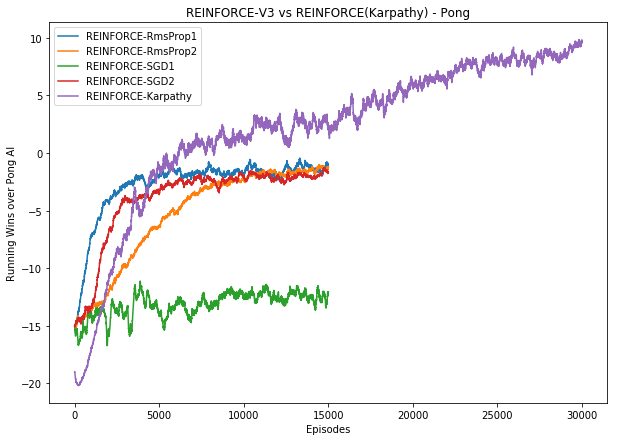

In [10]:
data2 = pickle.load(open('./results/pg-numpy/reward_history-pg-numpy-30000ep-lr-1e-3.p', 'rb'))
data1 = pickle.load(open('./results/reinforce/reinforce-v4/pong_RmsProp-lr=1e-3ep=15001history.p', 'rb'))
data3 = pickle.load(open('./results/reinforce/reinforce-v4/pong_RmsProp-lr=1e-4ep=15001history.p', 'rb'))
data4 = pickle.load(open('./results/reinforce/reinforce-v4/pong_SGD-lr=1e-3ep=15001history.p', 'rb'))
data5 = pickle.load(open('./results/reinforce/reinforce-v4/pong_SGD-lr=1e-4ep=15001history.p', 'rb'))

# Plot out reward and running reward over training episodes
plt.figure(figsize=(10, 7))


plt.plot(list(range(15001)), np.array(data1)[:,1], label='REINFORCE-RmsProp1')
plt.plot(list(range(15001)), np.array(data3)[30002:,1], label='REINFORCE-RmsProp2')
plt.plot(list(range(15001)), np.array(data4)[15001:,1], label='REINFORCE-SGD1')
plt.plot(list(range(15001)), np.array(data5)[45003:,1], label='REINFORCE-SGD2')
plt.plot(list(range(1,len(data2)+1)), np.array(data2)[:,1], label='REINFORCE-Karpathy')
plt.title('REINFORCE-V3 vs REINFORCE(Karpathy) - Pong')
plt.xlabel('Episodes')
plt.ylabel('Running Wins over Pong AI')
plt.legend()
plt.show()

## REINFORCE-Pong V5

We tried a few more changes to get the Pytorch code closer to Karpathy's REINFORCE, but all to no avail.

Pytorch's starter code for REINFORCE works only on Cartpole and cannot be scaled to a more complex problem as Pong. While it is learning, the resulting agent severely underperforms compared to Karpathy's implementation. 

The agents are stuck in local optima and incapable of exploring better strategies.


In [ ]:
import argparse
import gym
import numpy as np
from itertools import count

# For memory tracking
from pympler import summary
from pympler import muppy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.distributions import Categorical
import gc

gamma=0.99
render=False
load = False   # Load a pre-trained model
log_interval=10
batch_size = 800  # Debug Underperformance - (2) change batch_size
verbose=False  # To step through the code and understand what is going on

reinforce=[]

env = gym.make("Pong-v0")

# The function approximator of the Policy is a 2 layer NN. 
# - The policy takes in the state of Pong, which is a resampled 40x40 image
# - The action is the softmax output (Left or Right)
# - there are 200 hidden units in the NN
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.affine1 = nn.Linear(6400, 200)
        self.affine2 = nn.Linear(200, 2)  
        
        self.saved_log_probs = []
        self.rewards = []

    def forward(self, x):
        x = F.relu(self.affine1(x))
        action_scores = self.affine2(x)
        return action_scores   # output logit


# Debug Underperformance - (1) Change downsampling
def prepro80(I):
    """ 
    prepro 210x160x3 uint8 frame into 6400 (80x80) 1D float vector 
    """
    I = I[35:195] # crop
    I = I[::2,::2,0] # downsample by factor of 2
    I[I == 144] = 0 # erase background (background type 1)
    I[I == 109] = 0 # erase background (background type 2)
    I[I != 0] = 1 # everything else (paddles, ball) just set to 1
    return I.astype(np.float).ravel()


def select_action(state):
    """ 
    Use Policy to select an action based on state returned by Pong. The output expected by the PONG 
    is:
    ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']
    
    So we need to return 2 (UP/RIGHT) and 3(DOWN/LEFT)
    """
    
    state = torch.from_numpy(state).float().unsqueeze(0)
    
    # Use Policy to generate probability for action
    logit = policy(Variable(state.type(gpu_dtype), requires_grad=False))

    # Replace PyTorch recommended RL implementation
    # Sample action stochastically    
    # m = Categorical(probs)
    # action = m.sample()

    prob = F.softmax(logit, dim=1)
    log_prob = F.log_softmax(logit, dim=1)
    action = prob.multinomial().data   # action is sampled here
    
    if verbose:
        print ("Pong's state output:", state.shape)
        print ("NN output:", logit)
        print ("Pong Action:", action)
        print ("log_prob(action):", log_prob)
        
    log_prob = log_prob.gather(1, Variable(action))
        
    # Store log_prob (score function) into a list for calculating policy gradient    
    policy.saved_log_probs.append(log_prob)
    
    if verbose:
        print ("Stacked log_prob:", policy.saved_log_probs)
    
    return action


def finish_batch():
    """ 
    Based on REINFORCE, policy gradient is computed at the end of a batch (instead of an
    episode). It is then used to update the Policy's weights
    """

    R = 0
    policy_loss = []
    rewards = []   # This is v_t
    
    if verbose:    
        print ("Rewards:", policy.rewards)
            
    # In the main loop, reward for each time step is stored in the list policy.rewards[].
    # At the end of the episode, this is used to generate v_t for each time step.
    for r in policy.rewards[::-1]:
        if r != 0:  # reset the sum, since this was a game boundary (pong specific!)
            R = 0
        R = r + gamma * R
        rewards.insert(0, R)
        
    if verbose:    
        print ("Discounted Rewards:", rewards)
       
    rewards = torch.Tensor(rewards)
    
    # standardize the rewards to be unit normal (helps control the gradient estimator variance)
    rewards = (rewards - rewards.mean()) / (rewards.std() + np.finfo(np.float32).eps)

    if verbose:
        print ("v_t:", rewards)   

    # Calculate policy gradient ∇_θ log (π_θ ( s_t , a_t ) )v_t
    for log_prob, reward in zip(policy.saved_log_probs, rewards):
        policy_loss.append(-log_prob * reward)   # negative because gradient descent

    if verbose:
        print ("Policy Gradient:", policy_loss)  
        
    optimizer.zero_grad()  # zero the gradients before running the optimizer
    
    # Sum policy gradients for all time steps in the episode
    policy_loss = torch.cat(policy_loss).sum()   
    if verbose:
        print ("Policy loss (after cat and sum):", policy_loss)  
        
    # The TRICK: backward() on policy_loss instead of policy
    # Policy's parameters are updated here.
    policy_loss.backward()  
    optimizer.step()
    
    del policy.rewards[:]
    del policy.saved_log_probs[:]


    # Call an instance of the Policy and select ADAM as update rule
policy = Policy().cuda()
optimizer = optim.RMSprop(policy.parameters(), lr=5e-5, weight_decay=0.01)  # RMSProp instead of ADAM

if load is True:
    file_name='./results/reinforce/pong_ep=20000model.pt'
    policy.load_state_dict(torch.load(file_name))

# Main loop
prev_x = None
running_reward = -15

start = time.time()
# for i_episode in count(1):  # Infinite loop
for i_episode in range(30000+1): # just run 30000 episode    
    state = env.reset()
    reward_sum = 0
    
    for t in range(10000):  # Don't infinite loop while learning
        
        # Downsample 210x160x3 frame into 6400 (80x80) 1D float vector
        cur_x = prepro80(state)
        state = cur_x - prev_x if prev_x is not None else np.zeros(6400)
        prev_x = cur_x
        
        # Sample an action from Policy based on state provided by env
        action = select_action(state)
        
        action = action.cpu().numpy()+2
        
        if verbose:
            print ("Converted action: ", action)
            
        
        # step env through the sampled action
        state, reward, done, _ = env.step(action)  # UP=2, DOWN=3
        reward_sum += reward
        
        if render:
            env.render()
            
        # append reward to policy.reward[]
        # this is needed to calculate policy gradient at the end of the episode  
        policy.rewards.append(reward)
        
        if done or t > batch_size:
            break
        

    # Calculate policy gradient and update Policy 
    finish_batch()
    gc.collect()  # clean up some garbage
    torch.cuda.empty_cache()  # Release GPU memory
    
    running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
   
    reinforce.append([reward_sum, running_reward])
    # print out and show sign of life
    if i_episode % log_interval == 0:
        print('Episode {}\tLast Reward: {:.2f}\tRunning Reward: {:.2f}'.format(
                i_episode, reward_sum, running_reward))
    
    # track memory usage every 100 episodes
    if i_episode % 2000 == 0:
         # summary.print_(summary.summarize(muppy.get_objects()))
         file_name = './results/reinforce/pong_'+'ep='+str(i_episode)+'model.pt'
         torch.save(policy.state_dict(), file_name)


end = time.time()
print ("Time taken:", start-end)
env.close()

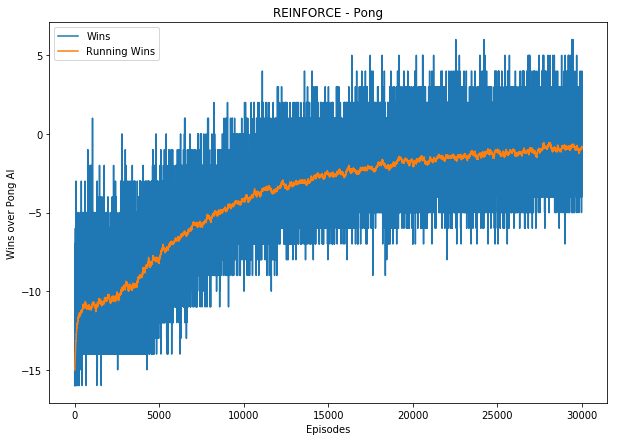

In [3]:
data = reinforce

# Plot out reward and running reward over training episodes
plt.figure(figsize=(10, 7))

plt.plot(list(range(1,len(np.array(data)[:,0])+1)), np.array(data)[:,0], label='Wins')
plt.plot(list(range(1,len(np.array(data)[:,1])+1)), np.array(data)[:,1], label='Running Wins')
plt.title('REINFORCE - Pong')
plt.xlabel('Episodes')
plt.ylabel('Wins over Pong AI')
plt.legend()
plt.show()

In [4]:
name = 'RmsProp-lr5e-5'
history_file = './results/reinforce/pong_'+name+'ep='+str(i_episode+1)+'history.p'
pickle.dump(reinforce, open(history_file, 'wb'))

## Definite Underperformance

Pytorch's recommended approach to RL severely underperforms compared to Karpathy's direct backprop approach. The agents are stuck in local optima and incapable of exploring better strategies.

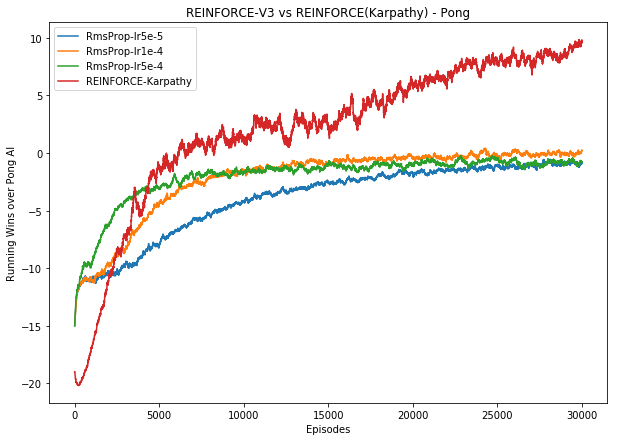

In [12]:
data1 = pickle.load(open('./results/reinforce/pong_RmsProp-lr5e-5ep=30001history.p', 'rb'))
data2 = pickle.load(open('./results/pg-numpy/reward_history-pg-numpy-30000ep-lr-1e-3.p', 'rb'))
data3 = pickle.load(open('./results/reinforce/pong_RmsProp-lr1e-4ep=30001history.p', 'rb'))
data4 = pickle.load(open('./results/reinforce/pong_RmsProp-lr5e-4ep=30001history.p', 'rb'))

# Plot out reward and running reward over training episodes
plt.figure(figsize=(10, 7))


plt.plot(list(range(1,len(data1)+1)), np.array(data1)[:,1], label='RmsProp-lr5e-5')
plt.plot(list(range(1,len(data3)+1)), np.array(data3)[:,1], label='RmsProp-lr1e-4')
plt.plot(list(range(1,len(data4)+1)), np.array(data4)[:,1], label='RmsProp-lr5e-4')
plt.plot(list(range(1,len(data2)+1)), np.array(data2)[:,1], label='REINFORCE-Karpathy')
plt.title('REINFORCE-V3 vs REINFORCE(Karpathy) - Pong')
plt.xlabel('Episodes')
plt.ylabel('Running Wins over Pong AI')
plt.legend()
plt.show()

## REINFORCE-V6

My fellow student Chris Lamb was able to get his Actor-Critic agent to get out of the local optima by implementing temperature to policy's softmax classifier.

In V6, we test to see if we can reduce model complexity (200 hidden unit to 128) to solve the local optima problem. It does not.

Thus endth our adventure in REINFORCE. Onto Actor-Critic!!!

In [ ]:
import argparse
import gym
import numpy as np
from itertools import count

# For memory tracking
from pympler import summary
from pympler import muppy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.distributions import Categorical
import gc

gamma=0.99
render=False
load = False   # Load a pre-trained model
log_interval=10
batch_size = 800  # Debug Underperformance - (2) change batch_size
verbose=False  # To step through the code and understand what is going on

reinforce=[]

env = gym.make("Pong-v0")

# The function approximator of the Policy is a 2 layer NN. 
# - The policy takes in the state of Pong, which is a resampled 40x40 image
# - The action is the softmax output (Left or Right)
# - there are 200 hidden units in the NN
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.affine1 = nn.Linear(6400, 128)
        self.affine2 = nn.Linear(128, 2)  
        
        self.saved_log_probs = []
        self.rewards = []

    def forward(self, x):
        x = F.relu(self.affine1(x))
        action_scores = self.affine2(x)
        return action_scores   # output logit


# Debug Underperformance - (1) Change downsampling
def prepro80(I):
    """ 
    prepro 210x160x3 uint8 frame into 6400 (80x80) 1D float vector 
    """
    I = I[35:195] # crop
    I = I[::2,::2,0] # downsample by factor of 2
    I[I == 144] = 0 # erase background (background type 1)
    I[I == 109] = 0 # erase background (background type 2)
    I[I != 0] = 1 # everything else (paddles, ball) just set to 1
    return I.astype(np.float).ravel()


def select_action(state):
    """ 
    Use Policy to select an action based on state returned by Pong. The output expected by the PONG 
    is:
    ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']
    
    So we need to return 2 (UP/RIGHT) and 3(DOWN/LEFT)
    """
    
    state = torch.from_numpy(state).float().unsqueeze(0)
    
    # Use Policy to generate probability for action
    logit = policy(Variable(state.type(gpu_dtype), requires_grad=False))

    # Replace PyTorch recommended RL implementation
    # Sample action stochastically    
    # m = Categorical(probs)
    # action = m.sample()

    prob = F.softmax(logit, dim=1)
    log_prob = F.log_softmax(logit, dim=1)
    action = prob.multinomial().data   # action is sampled here
    
    if verbose:
        print ("Pong's state output:", state.shape)
        print ("NN output:", logit)
        print ("Pong Action:", action)
        print ("log_prob(action):", log_prob)
        
    log_prob = log_prob.gather(1, Variable(action))
        
    # Store log_prob (score function) into a list for calculating policy gradient    
    policy.saved_log_probs.append(log_prob)
    
    if verbose:
        print ("Stacked log_prob:", policy.saved_log_probs)
    
    return action


def finish_batch():
    """ 
    Based on REINFORCE, policy gradient is computed at the end of a batch (instead of an
    episode). It is then used to update the Policy's weights
    """

    R = 0
    policy_loss = []
    rewards = []   # This is v_t
    
    if verbose:    
        print ("Rewards:", policy.rewards)
            
    # In the main loop, reward for each time step is stored in the list policy.rewards[].
    # At the end of the episode, this is used to generate v_t for each time step.
    for r in policy.rewards[::-1]:
        if r != 0:  # reset the sum, since this was a game boundary (pong specific!)
            R = 0
        R = r + gamma * R
        rewards.insert(0, R)
        
    if verbose:    
        print ("Discounted Rewards:", rewards)
       
    rewards = torch.Tensor(rewards)
    
    # standardize the rewards to be unit normal (helps control the gradient estimator variance)
    rewards = (rewards - rewards.mean()) / (rewards.std() + np.finfo(np.float32).eps)

    if verbose:
        print ("v_t:", rewards)   

    # Calculate policy gradient ∇_θ log (π_θ ( s_t , a_t ) )v_t
    for log_prob, reward in zip(policy.saved_log_probs, rewards):
        policy_loss.append(-log_prob * reward)   # negative because gradient descent

    if verbose:
        print ("Policy Gradient:", policy_loss)  
        
    optimizer.zero_grad()  # zero the gradients before running the optimizer
    
    # Sum policy gradients for all time steps in the episode
    policy_loss = torch.cat(policy_loss).sum()   
    if verbose:
        print ("Policy loss (after cat and sum):", policy_loss)  
        
    # The TRICK: backward() on policy_loss instead of policy
    # Policy's parameters are updated here.
    policy_loss.backward()  
    optimizer.step()
    
    del policy.rewards[:]
    del policy.saved_log_probs[:]


    # Call an instance of the Policy and select ADAM as update rule
policy = Policy().cuda()
optimizer = optim.RMSprop(policy.parameters(), lr=1e-3, weight_decay=0.01)  # RMSProp instead of ADAM

if load is True:
    file_name='./results/reinforce/pong_ep=20000model.pt'
    policy.load_state_dict(torch.load(file_name))

# Main loop
prev_x = None
running_reward = -15

start = time.time()
# for i_episode in count(1):  # Infinite loop
for i_episode in range(30000+1): # just run 30000 episode    
    state = env.reset()
    reward_sum = 0
    
    for t in range(10000):  # Don't infinite loop while learning
        
        # Downsample 210x160x3 frame into 6400 (80x80) 1D float vector
        cur_x = prepro80(state)
        state = cur_x - prev_x if prev_x is not None else np.zeros(6400)
        prev_x = cur_x
        
        # Sample an action from Policy based on state provided by env
        action = select_action(state)
        
        action = action.cpu().numpy()+2
        
        if verbose:
            print ("Converted action: ", action)
            
        
        # step env through the sampled action
        state, reward, done, _ = env.step(action)  # UP=2, DOWN=3
        reward_sum += reward
        
        if render:
            env.render()
            
        # append reward to policy.reward[]
        # this is needed to calculate policy gradient at the end of the episode  
        policy.rewards.append(reward)
        
        if done or t > batch_size:
            break
        

    # Calculate policy gradient and update Policy 
    finish_batch()
    gc.collect()  # clean up some garbage
    torch.cuda.empty_cache()  # Release GPU memory
    
    running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
   
    reinforce.append([reward_sum, running_reward])
    # print out and show sign of life
    if i_episode % log_interval == 0:
        print('Episode {}\tLast Reward: {:.2f}\tRunning Reward: {:.2f}'.format(
                i_episode, reward_sum, running_reward))
    
    # save model every 4000 episodes
    if i_episode % 4000 == 0:
         file_name = './results/reinforce/pong_'+'ep='+str(i_episode)+'model.pt'
         torch.save(policy.state_dict(), file_name)


end = time.time()
print ("Time taken:", start-end)
env.close()

In [4]:
name = '100hidden'
history_file = './results/reinforce/pong_'+name+'ep='+str(i_episode+1)+'history.p'
pickle.dump(reinforce, open(history_file, 'wb'))

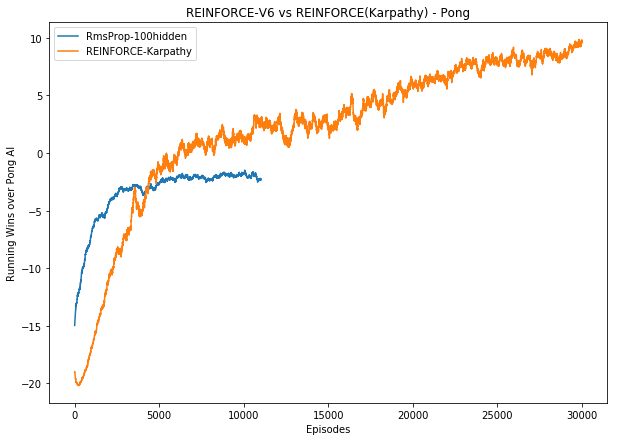

In [13]:
data1 = pickle.load(open('./results/reinforce/pong_100hiddenep=11012history.p', 'rb'))
data2 = pickle.load(open('./results/pg-numpy/reward_history-pg-numpy-30000ep-lr-1e-3.p', 'rb'))

# Plot out reward and running reward over training episodes
plt.figure(figsize=(10, 7))


plt.plot(list(range(1,len(data1)+1)), np.array(data1)[:,1], label='RmsProp-100hidden')
plt.plot(list(range(1,len(data2)+1)), np.array(data2)[:,1], label='REINFORCE-Karpathy')
plt.title('REINFORCE-V6 vs REINFORCE(Karpathy) - Pong')
plt.xlabel('Episodes')
plt.ylabel('Running Wins over Pong AI')
plt.legend()
plt.show()